Analiza si Compararea Metoddelor Supervizate de Clasificare pe Imagini Hiperspectrale

In [2]:

try:
    import os
    import numpy as np
    import pandas as pd
    import rasterio
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.decomposition import PCA
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.datasets import make_classification
    from sklearn.metrics import (accuracy_score, confusion_matrix, 
                                  classification_report, f1_score, 
                                  recall_score, precision_score, ConfusionMatrixDisplay)
    from skimage.transform import resize
except ImportError as e:
    print(f"Eroare la încărcarea bibliotecilor: {e}")
    import sys
    !{sys.executable} -m pip install --upgrade --force-reinstall numpy pandas scikit-learn rasterio matplotlib seaborn scikit-image
    

- Functie recursivă pentru a incarca imagini dintr-un folder si subfolderele acestuia in care parcurgem fiecare categorie din setul de date si redimensionam unele poze pentru ca nu aveau toate aceeasi marime

In [3]:
def load_images_from_folder(folder, target_size=(64, 64)):
    images = []
    labels = []
    
    
    for category in os.listdir(folder):
        category_path = os.path.join(folder, category)
        if os.path.isdir(category_path): 
            print(f"Citire imagini din categoria: {category}")  
            for subfolder_path, _, files in os.walk(category_path):
                for file in files:
                    if file.endswith('.tif'):  
                        image_path = os.path.join(subfolder_path, file)
                        try:
                            with rasterio.open(image_path) as src:
                                img_data = src.read()  
                                img_data = np.moveaxis(img_data, 0, -1)  
                                
                                img_resized = resize(img_data, target_size + (img_data.shape[2],), mode='reflect')
                                
                                images.append(img_resized)
                                labels.append(category)
                        except Exception as e:
                            print(f"Eroare la citirea imaginii {image_path}: {e}")
    
    return np.array(images), np.array(labels)

- Incarcare set de date: https://www.kaggle.com/datasets/warcoder/apple-hyperspectral-images-dataset

In [4]:
folder_path = './Apple-Hyperspectral-Images'  
X, y = load_images_from_folder(folder_path)
if X.size == 0:
    print("Eroare: Nu au fost găsite imagini valide în setul de date.")
else:
    print(f"Număr imagini încărcate: {X.shape[0]}")

Citire imagini din categoria: Apple_Samples


C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Citire imagini din categoria: Fungicide_Apple
Citire imagini din categoria: Insecticide_Apple
Număr imagini încărcate: 617


Normalizam datele pentru SVM si reducem dimensionalitatea pentru PCA

In [5]:
if X.size > 0:
    scaler = StandardScaler()
    X = X.reshape(X.shape[0], -1)   
    X = scaler.fit_transform(X)

    pca = PCA(n_components=50) 
    X_pca = pca.fit_transform(X)

    
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

    print(f'Antrenament: {X_train.shape}, Test: {X_test.shape}')

Antrenament: (431, 50), Test: (186, 50)


 - # SVM - antrenare

In [6]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    random_state=42,
    n_classes=3,
)
train_results = []

kernel_types = ["linear", "rbf", "poly"]
for kernel in kernel_types:
    svm_model = SVC(kernel=kernel)
    svm_model.fit(X_train, y_train)
    y_pred_svm_train = svm_model.predict(X_train)  #
    
    accuracy_svm_train = accuracy_score(y_train, y_pred_svm_train)
    precision_svm_train = precision_score(y_train, y_pred_svm_train, average="weighted")
    recall_svm_train = recall_score(y_train, y_pred_svm_train, average="weighted")
    f1_svm_train = f1_score(y_train, y_pred_svm_train, average="weighted")
    
    train_results.append({
        "Model": f"SVM ({kernel})",
        "Acuratețe": accuracy_svm_train,
        "Precizie": precision_svm_train,
        "Recuperare": recall_svm_train,
        "F1": f1_svm_train,
    })
    print(f'Acuratețe SVM antrenare (kernel={kernel}): {accuracy_svm_train}')

Acuratețe SVM antrenare (kernel=linear): 1.0
Acuratețe SVM antrenare (kernel=rbf): 0.9651972157772621
Acuratețe SVM antrenare (kernel=poly): 0.9303944315545244


- # SVM- testare

In [7]:


results = []

kernel_types = ["linear", "rbf", "poly"]

for kernel in kernel_types:
    
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)

    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    precision_svm = precision_score(y_test, y_pred_svm, average="weighted")
    recall_svm = recall_score(y_test, y_pred_svm, average="weighted")
    f1_svm = f1_score(y_test, y_pred_svm, average="weighted")

 Evaluarea performantei SVM:

Acuratețe SVM (kernel=poly): 0.8870967741935484
Precizie SVM (kernel=poly): 0.9130568356374807
Recuperare SVM (kernel=poly): 0.8870967741935484
F1 SVM (kernel=poly): 0.883650399779432
Raport de clasificare (SVM):
                   precision    recall  f1-score   support

    Apple_Samples       0.99      0.99      0.99        93
  Fungicide_Apple       0.97      0.60      0.74        48
Insecticide_Apple       0.70      0.98      0.81        45

         accuracy                           0.89       186
        macro avg       0.88      0.86      0.85       186
     weighted avg       0.91      0.89      0.88       186



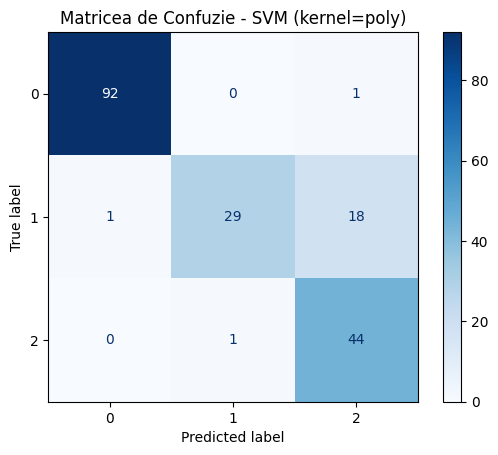

In [8]:
results.append({
        "Kernel": kernel,
        "Acuratețe": accuracy_svm,
        "Precizie": precision_svm,
        "Recuperare": recall_svm,
        "F1": f1_svm,
    })
comparison_results = []
comparison_results.append({
    "Model": f"SVM ({kernel})",
    "Acuratețe": accuracy_svm,
    "Precizie": precision_svm,
    "Recuperare": recall_svm,
    "F1": f1_svm
})

classification_report_svm = classification_report(y_test, y_pred_svm)
print(f'Acuratețe SVM (kernel={kernel}): {accuracy_svm}')
print(f'Precizie SVM (kernel={kernel}): {precision_svm}')
print(f'Recuperare SVM (kernel={kernel}): {recall_svm}')
print(f'F1 SVM (kernel={kernel}): {f1_svm}')
print('Raport de clasificare (SVM):')
print(classification_report_svm)


confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svm, display_labels=np.unique(y))
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Matricea de Confuzie - SVM (kernel={kernel})")
plt.show()

In [ ]:
Random Forest:

In [9]:
print("Antrenarea modelului Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)



Antrenarea modelului Random Forest...


RandomForestClassifier()

In [10]:

def evaluate_model(model, X, y, dataset_name, model_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    
    print(f"Rezultate pentru {model_name} pe {dataset_name}:")
    print(f"Acuratețe: {accuracy}")
    print(f"Precizie: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Raport de clasificare:")
    print(classification_report(y, y_pred))
    
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"Matrice de confuzie pentru {model_name} ({dataset_name})")
    plt.show()
    comparison_results.append({
    "Model": {model_name},
    "Acuratețe": {accuracy},
    "Precizie": {precision},
    "Recuperare": {recall},
    "F1": {f1}
})

# Evaluare pe setul de antrenament

Rezultate pentru Random Forest pe antrenament:
Acuratețe: 1.0
Precizie: 1.0
Recall: 1.0
F1-Score: 1.0
Raport de clasificare:
                   precision    recall  f1-score   support

    Apple_Samples       1.00      1.00      1.00       187
  Fungicide_Apple       1.00      1.00      1.00       114
Insecticide_Apple       1.00      1.00      1.00       130

         accuracy                           1.00       431
        macro avg       1.00      1.00      1.00       431
     weighted avg       1.00      1.00      1.00       431



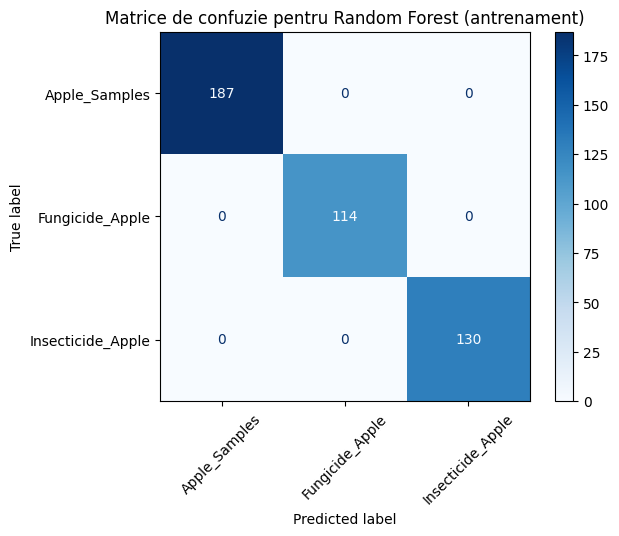

In [11]:
evaluate_model(rf_model, X_train, y_train, "antrenament", "Random Forest")

Rezultate pentru Random Forest pe testare:
Acuratețe: 0.9301075268817204
Precizie: 0.930466679583466
Recall: 0.9301075268817204
F1-Score: 0.9296947271045327
Raport de clasificare:
                   precision    recall  f1-score   support

    Apple_Samples       0.96      0.98      0.97        93
  Fungicide_Apple       0.93      0.85      0.89        48
Insecticide_Apple       0.87      0.91      0.89        45

         accuracy                           0.93       186
        macro avg       0.92      0.91      0.92       186
     weighted avg       0.93      0.93      0.93       186



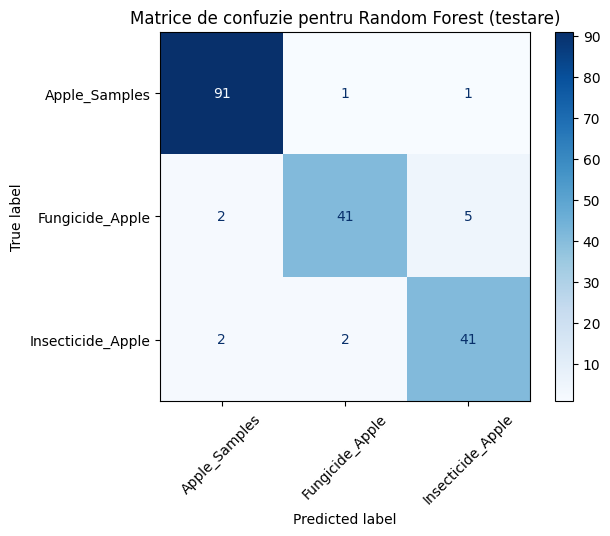

In [12]:
evaluate_model(rf_model, X_test, y_test, "testare", "Random Forest")

# - NN(Neural Networks) 


Antrenarea modelului Neural Network (NN)...
Rezultate pentru Neural Network pe antrenament:
Acuratețe: 0.974477958236659
Precizie: 0.9744003699745097
Recall: 0.974477958236659
F1-Score: 0.9744317814665843
Raport de clasificare:
                   precision    recall  f1-score   support

    Apple_Samples       0.99      1.00      1.00       187
  Fungicide_Apple       0.96      0.96      0.96       114
Insecticide_Apple       0.96      0.95      0.96       130

         accuracy                           0.97       431
        macro avg       0.97      0.97      0.97       431
     weighted avg       0.97      0.97      0.97       431



C:\Users\alexa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


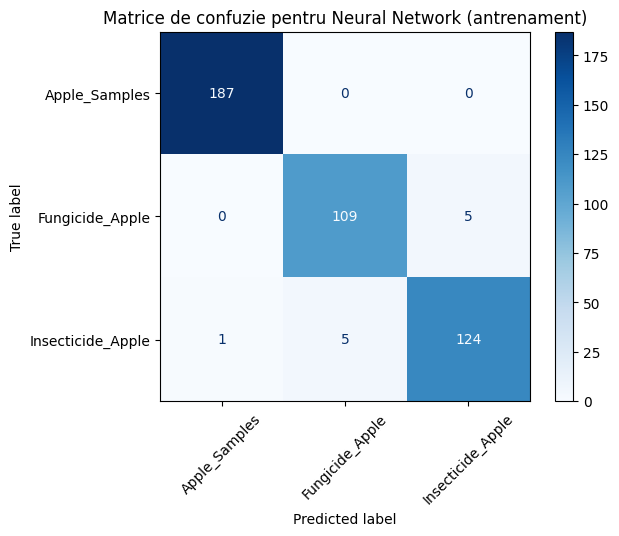

In [28]:

print("\nAntrenarea modelului Neural Network (NN)...")
nn_model = MLPClassifier(
    hidden_layer_sizes=(20,),      activation='relu',         
    solver='adam',             
    max_iter=100,              
    random_state=42
)
nn_model.fit(X_train, y_train)


evaluate_model(nn_model, X_train, y_train, "antrenament", "Neural Network")


NN testare

Rezultate pentru Neural Network pe testare:
Acuratețe: 0.8225806451612904
Precizie: 0.8150981767180926
Recall: 0.8225806451612904
F1-Score: 0.8175803491620083
Raport de clasificare:
                   precision    recall  f1-score   support

    Apple_Samples       0.91      0.98      0.94        93
  Fungicide_Apple       0.74      0.71      0.72        48
Insecticide_Apple       0.70      0.62      0.66        45

         accuracy                           0.82       186
        macro avg       0.78      0.77      0.78       186
     weighted avg       0.82      0.82      0.82       186



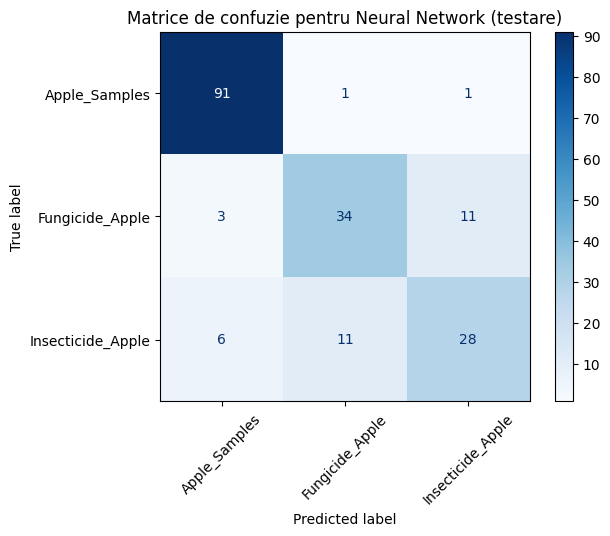

In [29]:
evaluate_model(nn_model, X_test, y_test, "testare", "Neural Network")

C:\Users\alexa\AppData\Local\Temp\ipykernel_4648\3889245051.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=comparison_df, x="Model", y="Acuratețe", palette="Set2")


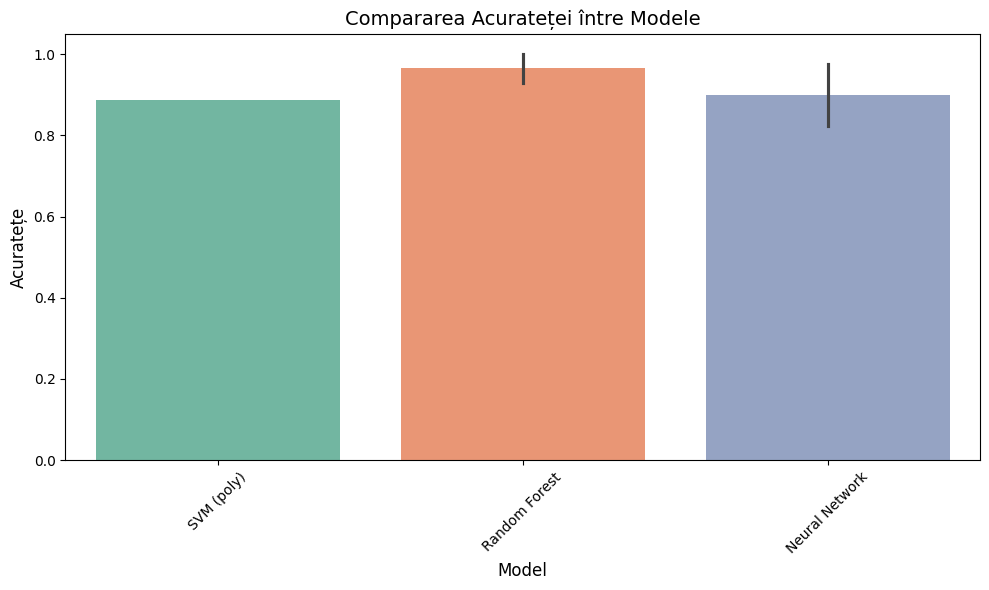

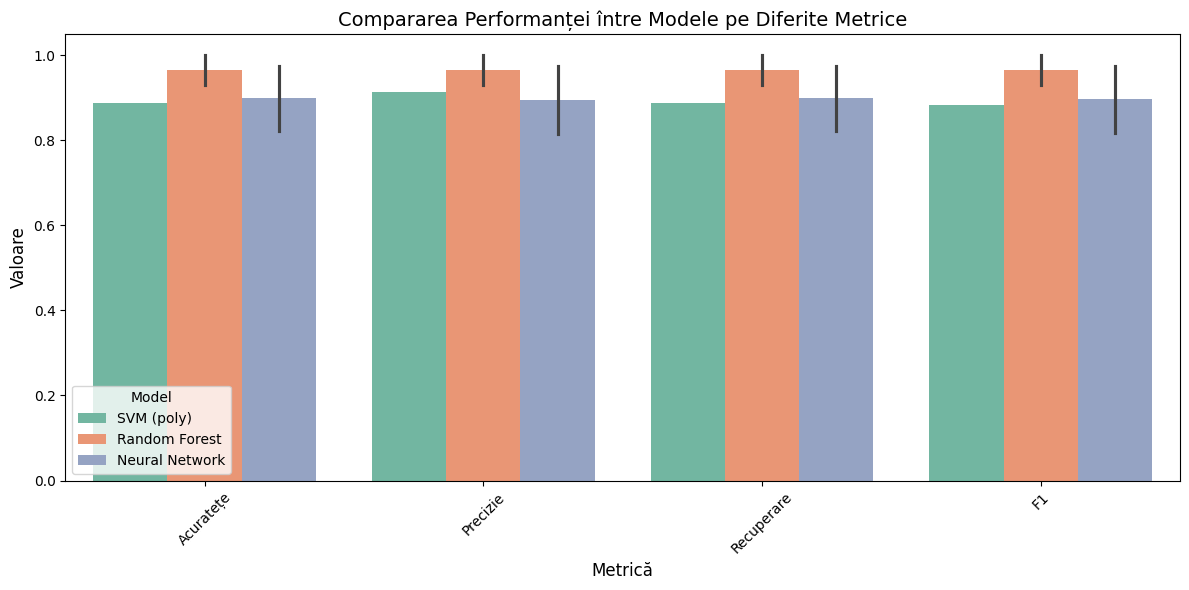

In [32]:
comparison_df = pd.DataFrame(comparison_results)

plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x="Model", y="Acuratețe", palette="Set2")
plt.title("Compararea Acurateței între Modele", fontsize=14)
plt.ylabel("Acuratețe", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


comparison_melted = comparison_df.melt(id_vars="Model", var_name="Metrică", value_name="Valoare")


plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_melted, x="Metrică", y="Valoare", hue="Model", palette="Set2")
plt.title("Compararea Performanței între Modele pe Diferite Metrice", fontsize=14)
plt.ylabel("Valoare", fontsize=12)
plt.xlabel("Metrică", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Model", fontsize=10)
plt.tight_layout()
plt.show()

Random Forest a avut cele mai bune rezultate pentru ca este un algoritm bazat pe ansambluri de arbori de decizie care combina mai multe modele pentru a reduce overfitting-ul. Se vede si in graficul pe care l-am facut pentru a arata performantele metodelor supervizate.

Comparare:
 - SVM bun pe seturi de date mici, mai putin predispus la overfitting.
 - Random Forest e mai potrivit pentru date cu zgomot
 - NN Poate fi ajustat si extins prin numarul de straturi si de neuroni

Dezavantaje:
1. SVM: Pentru seturi mari de date este lent, e greu de ales un kernel care sa dea un randament bun si hiperparametrii greu de ales.
2. Random Forest: Consuma multa memorie si dureaza mai mult decat celelalte.
3. NN: Daca nu sunt multe date, e posibil sa faca overfitting si performanta este sensibila in functie de ce hiperparametrii alegi, rata de invatare, functia de activare.